# Double-checking FiveThirtyEight's 2016 Primary Predictions

Here I look at the [predictions that FiveThiryEight made](https://projects.fivethirtyeight.com/election-2016/primary-forecast/) about the 2016 Presidential Primaries.

## Loading the data

Load the data about their predictions and the actual outcomes into `pandas` dataframes:

In [1]:
# Load the dataframes from disk
import pandas as pd
dem = pd.read_csv("./2016_dem_primary_dataframe.csv", index_col=[0,1])
gop = pd.read_csv("./2016_gop_primary_dataframe.csv", index_col=[0,1])

In [2]:
# We only care about races where there was a prediction made
dem = dem.dropna()
gop = gop.dropna()

## Looking at the data

Let's look at the results for Iowa for the Democrats, just to see what is in the table.

In [3]:
dem.ix[["Iowa"]]

80% Lower Bound  80% Upper Bound  Result
State Candidate                                          
Iowa  Clinton               44.0             54.0    49.9
      O'Malley               4.0              8.0     0.6
      Sanders               40.0             52.0    49.6

The 80% confidence intervales are given by the "`80% Lower Bound`" and "`80% Upper Bound`" columns. The actually result of the election is given in the "`Result`" column.

Here is the data for Iowa for the Republicans:

In [4]:
gop.ix[["Iowa"]]

80% Lower Bound  80% Upper Bound  Result
State Candidate                                          
Iowa  Carson                 3.0             15.0     9.3
      Cruz                  14.0             36.0    27.6
      Kasich                 1.0              4.0     1.9
      Rubio                  9.0             27.0    23.1
      Trump                 15.0             38.0    24.3

## Checking the intervals

Now I'll add a set of columns that tells us if the prediction was good or not, that is, if the actual result was within the 80% confidence interval or not:

In [5]:
import numpy as np

def add_good_predicitons(df, name="Prediction Good"):
    cond = (df['80% Lower Bound'] <= df['Result']) & (df["Result"] <= df["80% Upper Bound"])
    df["Prediction Good"] = np.where(cond, True, False)
    df["Prediction Low"] = np.where(df["80% Upper Bound"] < df["Result"], True, False)
    df["Prediction High"] = np.where(df["Result"] < df["80% Lower Bound"], True, False)

In [6]:
add_good_predicitons(dem)
add_good_predicitons(gop)

In [7]:
dem.ix[["Iowa"]]

80% Lower Bound  80% Upper Bound  Result Prediction Good  \
State Candidate                                                             
Iowa  Clinton               44.0             54.0    49.9            True   
      O'Malley               4.0              8.0     0.6           False   
      Sanders               40.0             52.0    49.6            True   

                Prediction Low Prediction High  
State Candidate                                 
Iowa  Clinton            False           False  
      O'Malley           False            True  
      Sanders            False           False

In [8]:
# Compute how the results match the predictions
def get_low_right_high(df):
    r = df["Prediction Good"]
    right = float(r.sum()) / r.count()
    h = df["Prediction High"]
    high = float(h.sum()) / h.count()
    l = df["Prediction Low"]
    low = float(l.sum()) / l.count()
    
    return low, right, high

In [9]:
dem_low, dem_right, dem_high = get_low_right_high(dem)
gop_low, gop_right, gop_high = get_low_right_high(gop)

In [10]:
print "Party         Under   Right   Over   Total"
print "------------|-------------------------------"
print "Democrats   | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(dem_low, dem_right, dem_high, sum((dem_low, dem_right, dem_high)))
print "Republicans | {:.2%}, {:.2%}, {:.2%}, {:.2%}".format(gop_low, gop_right, gop_high, sum((gop_low, gop_right, gop_high)))

Party         Under   Right   Over   Total
------------|-------------------------------
Democrats   | 3.64%, 80.00%, 16.36%, 100.00%
Republicans | 7.14%, 77.68%, 15.18%, 100.00%


## Plotting the Results

We can make a plot of the actual voting results by scaling the vote share so that the low edge of the confidence interval is +1, the high edge is -1, and the midpoint is 0. Then if a candidate's vote share is within the predicted range their result will be between -1 and 1. If the prediction was 45% to 55% and the candidate actually got 60%, that would show up at -2 on the plot. The minus sign indicates that the prediction was too low.

In [11]:
def add_scaled_result(df):
    interval = (df["80% Upper Bound"] - df["80% Lower Bound"]) / 2.
    means = df["80% Lower Bound"] + interval
    # The - out front makes it so that if the prediction is 1 sigma high, we get a +1
    df["Scaled Result"] = -(df["Result"] - means) / interval

In [12]:
add_scaled_result(dem)
add_scaled_result(gop)

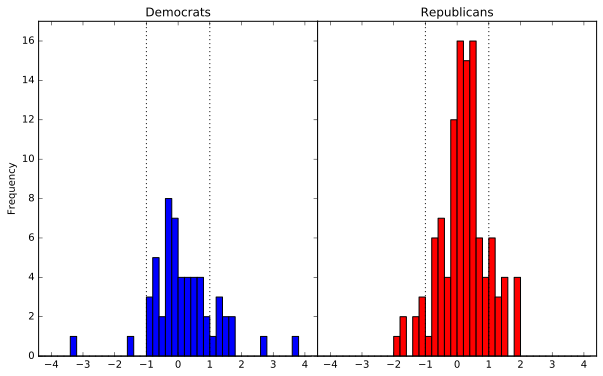

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

width = 10
height = 6

plt.figure(figsize=(width, height))

bins = [float(i)/10. for i in range(-44, 46, 2)]
ylim = [0, 17]
xlim = [min(bins), -min(bins)]


ax1 = plt.subplot2grid((1,2),(0,0))
ax2 = plt.subplot2grid((1,2),(0,1))

dem["Scaled Result"].plot(kind="hist", color='b', ax=ax1, ylim=ylim, xlim=xlim, bins=bins)
gop["Scaled Result"].plot(kind="hist", color='r', ax=ax2, ylim=ylim, xlim=xlim, bins=bins)

# 80% Confidence intervals
color="black"
linestyle="dotted"
ax1.axvline(-1, color=color, linestyle=linestyle)
ax1.axvline(+1, color=color, linestyle=linestyle)
ax2.axvline(-1, color=color, linestyle=linestyle)
ax2.axvline(+1, color=color, linestyle=linestyle)

ax1.set_title("Democrats")
ax2.set_title("Republicans")
ax2.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0)

plt.savefig("/tmp/538_scaled_results.png")

plt.show()

## A (Rough) Estimate of Uncertainties

When I read FiveThirtyEight's plots, I only ever pick a whole number (I certainly am not accurate enough to get better precision than that). I estimate that if I say a number is "34%", then it is just as likely to be 33 or 35. To estimate what effect this has, I randomly adjust the prediction bounds (up 1, down 1, or leaving it alone with equal probability) and see how the predictions fare. The number I report below is the mean of these trials, and the uncertainties represent two standard deviations.

In [14]:
import random
import numpy as np

def ugly_simulation_hack(df, sigma=1, iterations=10000, std_to_return=2):

    sim_good = []
    sim_low = []
    sim_high = []

    # Run many simulations
    for _ in xrange(iterations):

        pred_good = []
        pred_low = []
        pred_high = []

        # Check every prediction and perturb them
        for ((state, candidate), low, high, result, _, _, _, _) in df.itertuples():

            # Perturb the bounds I read from 538's plots assuming a Gaussian
            # distribution around the value
            #new_low = random.gauss(low, sigma)
            #new_high = random.gauss(high, sigma)
            new_low = random.randint(low-sigma, low+sigma)
            new_high = random.randint(high-sigma, high+sigma)

            # Check if the perturbed prediction is good or not
            pred_good.append(new_low <= result <= new_high)
            pred_low.append(new_high < result)
            pred_high.append(result < new_low)

        # Calculate the number correct accounting for the perturbations
        sim_good.append(sum(pred_good)/float(len(pred_good)))
        sim_low.append(sum(pred_low)/float(len(pred_low)))
        sim_high.append(sum(pred_high)/float(len(pred_high)))

    # Calculate outcome of the simulation
    good_mean = np.mean(sim_good)
    good_std = np.std(sim_good)
    low_mean = np.mean(sim_low)
    low_std = np.std(sim_low)
    high_mean = np.mean(sim_high)
    high_std = np.std(sim_high)

    return (
        good_mean,
        good_std * std_to_return,
        low_mean,
        low_std * std_to_return,
        high_mean,
        high_std * std_to_return,
    )

In [15]:
gop_good, gop_good_std, gop_low, gop_low_std, gop_high, gop_high_std = ugly_simulation_hack(gop)
dem_good, dem_good_std, dem_low, dem_low_std, dem_high, dem_high_std = ugly_simulation_hack(dem)

In [16]:
print "Party         Under           Right          Over"
print "------------|---------------------------------------------"
print "Democrats   | {:.1%} +- {:.1%}   {:.1%} +- {:.1%}   {:.1%} +- {:.1%}".format(dem_low, dem_low_std, dem_good, dem_good_std, dem_high, dem_high_std)
print "Republicans | {:.1%} +- {:.1%}   {:.1%} +- {:.1%}   {:.1%} +- {:.1%}".format(gop_low, gop_low_std, gop_good, gop_good_std, gop_high, gop_high_std)

Party         Under           Right          Over
------------|---------------------------------------------
Democrats   | 5.5% +- 3.0%   77.6% +- 4.2%   17.0% +- 3.0%
Republicans | 6.5% +- 1.2%   78.6% +- 3.3%   14.9% +- 3.1%
